In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

from os import listdir
from os.path import isfile, join
import pandas as pd
from sklearn.model_selection import train_test_split
import gc; gc.enable() # memory is tight

from keras import layers, models
from keras import backend as K
from keras.optimizers import Adam

In [148]:
path='/content/drive/MyDrive/Colab Notebooks/train/'

images = []
masks = []
#print(os.listdir(path))

for f in listdir(path):
  if f.endswith(".csv"):
    masks.append(path+f)
  else:
    images.append(path+f)

df = pd.DataFrame(np.column_stack([images, masks]), columns=['images', 'masks'])

In [149]:
df.head()

,images,masks
0,/content/drive/MyDrive/Colab Notebooks/train/0...,/content/drive/MyDrive/Colab Notebooks/train/0...
1,/content/drive/MyDrive/Colab Notebooks/train/0...,/content/drive/MyDrive/Colab Notebooks/train/0...
2,/content/drive/MyDrive/Colab Notebooks/train/0...,/content/drive/MyDrive/Colab Notebooks/train/0...
3,/content/drive/MyDrive/Colab Notebooks/train/0...,/content/drive/MyDrive/Colab Notebooks/train/0...
4,/content/drive/MyDrive/Colab Notebooks/train/0...,/content/drive/MyDrive/Colab Notebooks/train/0...


In [150]:
df1 = df.sort_values(by='images')['images'].reset_index()
# df1 = df.sort_values(by='a')['a']
df2 = df.sort_values(by='masks')['masks'].reset_index()
# df2 = df.sort_values(by='b')['b']
df['images'] = df1['images']
df['masks'] = df2['masks']
del df1, df2

In [151]:
df.head()

,images,masks
0,/content/drive/MyDrive/Colab Notebooks/train/0...,/content/drive/MyDrive/Colab Notebooks/train/0...
1,/content/drive/MyDrive/Colab Notebooks/train/0...,/content/drive/MyDrive/Colab Notebooks/train/0...
2,/content/drive/MyDrive/Colab Notebooks/train/0...,/content/drive/MyDrive/Colab Notebooks/train/0...
3,/content/drive/MyDrive/Colab Notebooks/train/0...,/content/drive/MyDrive/Colab Notebooks/train/0...
4,/content/drive/MyDrive/Colab Notebooks/train/0...,/content/drive/MyDrive/Colab Notebooks/train/0...


In [152]:
type(df)

pandas.core.frame.DataFrame

In [208]:
f=open(path+"0041e69431bf872309d1aff628b6494f.csv").readlines()
z= [x.split(",") for x in f]
type(z)


list

In [222]:
# csv path, img shape
# düzeltme yapılacak. bir fotoda birden çok eleman olması durumu için
def create_mask(mask_dir, img_shape):
    mask = np.zeros(shape=(img_shape[0], img_shape[1], 1))

    with open(mask_dir) as f:
        content = f.readlines()
    content = [x.split(",") for x in content]
    ul_col, ul_row = int(float(content[1][4])), int(float(content[1][5]))
    lr_col, lr_row = int(float(content[1][6])), int(float(content[1][7]))

    mask[ul_row:lr_row, ul_col:lr_col, 0] = 1 
    return mask

In [182]:
df_train, df_val = train_test_split(df, test_size=0.25, shuffle=False)
print(df_train)
print(type(df_train.images))
#print(df_val)
BATCH_SIZE = 64
EDGE_CROP = 16
NB_EPOCHS = 30
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
VALID_IMG_COUNT = 400
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False

                                                 images                                              masks
0     /content/drive/MyDrive/Colab Notebooks/train/0...  /content/drive/MyDrive/Colab Notebooks/train/0...
1     /content/drive/MyDrive/Colab Notebooks/train/0...  /content/drive/MyDrive/Colab Notebooks/train/0...
2     /content/drive/MyDrive/Colab Notebooks/train/0...  /content/drive/MyDrive/Colab Notebooks/train/0...
3     /content/drive/MyDrive/Colab Notebooks/train/0...  /content/drive/MyDrive/Colab Notebooks/train/0...
4     /content/drive/MyDrive/Colab Notebooks/train/0...  /content/drive/MyDrive/Colab Notebooks/train/0...
...                                                 ...                                                ...
1546  /content/drive/MyDrive/Colab Notebooks/train/8...  /content/drive/MyDrive/Colab Notebooks/train/8...
1547  /content/drive/MyDrive/Colab Notebooks/train/8...  /content/drive/MyDrive/Colab Notebooks/train/8...
1548  /content/drive/MyDrive/Colab No

In [203]:
def create_images_generator(df_in, batch_size, resized_shape):
    batch_image = []
    batch_mask = []
    df_in_list = df_in.values.tolist()
    #print(len(df_in_list))
    #np.random.shuffle(df_in_list)
    # return df_in_list    
    
    while True:
#         np.random.shuffle(df_in_list)
        for image_path, mask_path in df_in_list:
            image_r = cv2.imread(image_path)
            mask_r = create_mask(mask_path, image_r.shape)
            
            image_r = cv2.resize(image_r,(resized_shape[1], resized_shape[0]))
            mask_r = cv2.resize(mask_r,(resized_shape[1], resized_shape[0]))
            
            
            
            batch_image.append(image_r)
            batch_mask.append(mask_r)
            
            if len(batch_mask)>=batch_size:
                yield np.float32(np.stack((batch_image), 0)/255.0), np.stack(np.uint8(np.expand_dims(batch_mask, -1)), 0)
                batch_image, batch_mask = [], []

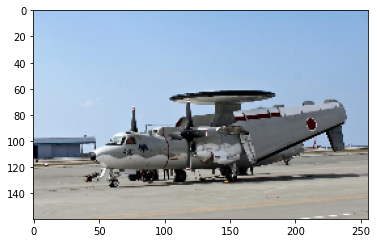

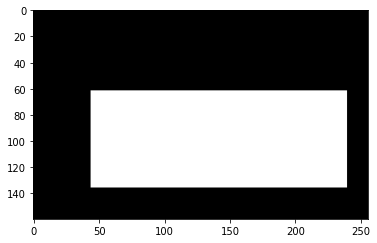

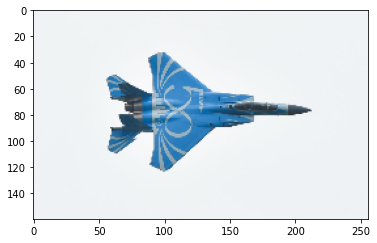

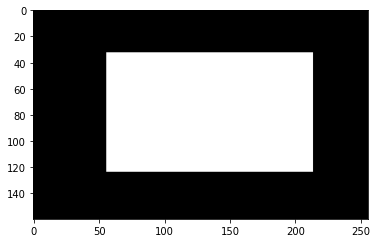

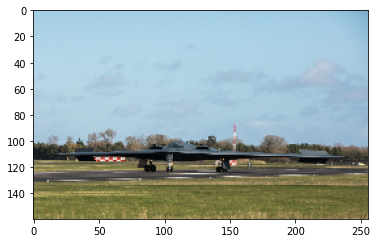

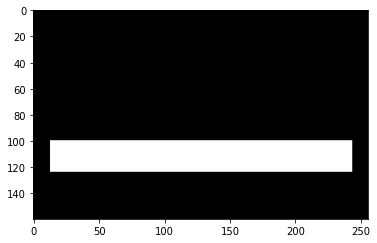

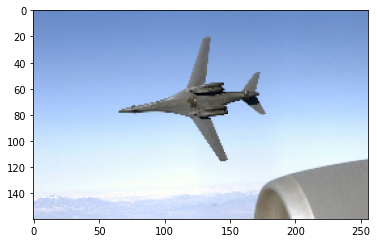

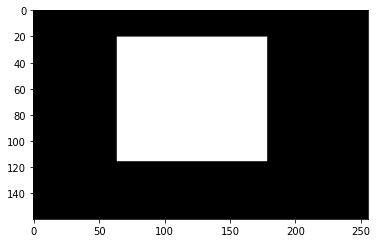

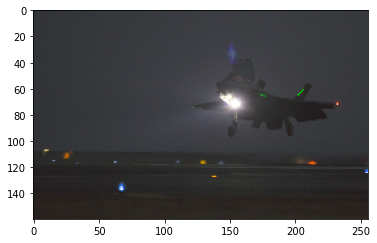

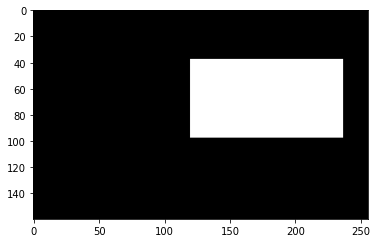

In [223]:
resized_shape = (160, 256)                
train_gen = create_images_generator(df_train, batch_size=BATCH_SIZE, resized_shape=resized_shape)
batch_img, batch_mask = next(train_gen)
for i in range(10):

    im = np.array(255*batch_img[i],dtype=np.uint8)
    im_mask = np.array(batch_mask[i],dtype=np.uint8)
    
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.figure()
    plt.imshow(im_mask[:,:,0], cmap= 'gray')
    plt.show()